In [95]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from IPython.display import display
import torch
from PIL import Image
import coremltools as ct
from huggingface_hub import hf_hub_download
import tempfile
import matplotlib
import numpy as np
from torch import nn

## Patch CoreMLTools

We need to patch the lack of `upsample_bicubic2d`.
Achieved by looking here:
- https://github.com/pytorch/pytorch/blob/ac5f565fa7010bd77b9e779415e8709d347234b6/aten/src/ATen/native/UpSample.cpp#L10
- https://github.com/pytorch/pytorch/blob/ac5f565fa7010bd77b9e779415e8709d347234b6/aten/src/ATen/native/UpSampleBicubic2d.cpp#L284
- https://apple.github.io/coremltools/docs-guides/source/composite-operators.html#using-composite-ops-with-pytorch-conversion
- https://github.com/huggingface/exporters/blob/7a545974275c7af167a2fa4e16c4574359f2acec/src/exporters/coreml/models.py#L530


In [96]:
from coremltools.converters.mil.frontend.torch.torch_op_registry import register_torch_op
from coremltools.converters.mil.frontend.torch.ops import _get_inputs
from coremltools.converters.mil import Builder as mb

@register_torch_op
def upsample_bicubic2d(context, node):
    inputs = _get_inputs(context, node)

    for input in inputs:
        print("DBS upsample_bicubic2d, input: ", input)
        if hasattr(input, 'name'):
            print("DBS upsample_bicubic2d, input name: ", input.name)
            if (input.name == '170' or input.name == '173') and hasattr(input, 'val'):
                print("DBS upsample_bicubic2d, input value: ", input.val)
        if hasattr(input, 'shape'):
            print("DBS upsample_bicubic2d, input shape: ", input.shape)
        if hasattr(input, 'dtype'):
            print("DBS upsample_bicubic2d, input dtype: ", input.dtype)
        if hasattr(input, 'type_str'):
            print("DBS upsample_bicubic2d, input type_str: ", input.type_str)
        print("\n")

    a = inputs[0]
    b = inputs[3]
    print("DBS upsample_bicubic2d, a: ", a)
    print("DBS upsample_bicubic2d, b: ", b)
    y = mb.resize_bilinear(
        x=a, 
        target_size_height=int(b.val[0] * a.shape[2]), 
        target_size_width=int(b.val[1] * a.shape[3]), 
        name=node.name
    )
    context.add(y)

ValueError: Torch op upsample_bicubic2d already registered.

## Import the DepthAnythingV2 model

The `depth_anything_v2` folder I copied directly from their huggingface repo: https://huggingface.co/spaces/depth-anything/Depth-Anything-V2/tree/main/depth_anything_v2

To make the code work, copy it / symlink it to the root of this folder

In [ ]:
from depth_anything_v2.dpt import DepthAnythingV2

xFormers not available
xFormers not available


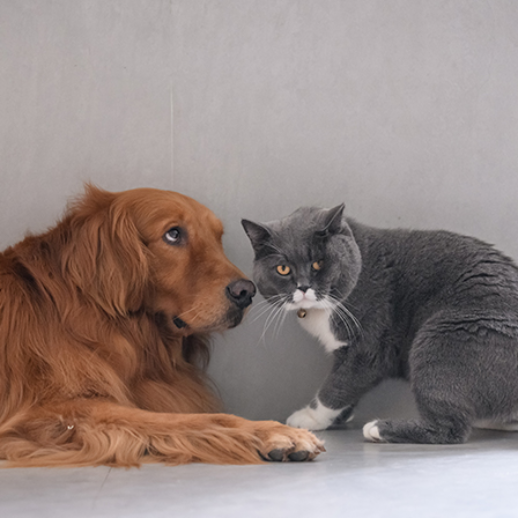

In [ ]:
image = Image.open("/Users/qhong/Downloads/cat_dog2.png")
image 

## Setup
This part I ported from the huggingface DepthAnythingV2 repo: https://huggingface.co/spaces/depth-anything/Depth-Anything-V2/blob/main/app.py

Load the model and put it in `eval` mode.

Change the `encoder` to the one of your choice.

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
encoder2name = {
    'vits': 'Small',
    'vitb': 'Base',
    'vitl': 'Large',
    'vitg': 'Giant', # UNAVAILABLE AS OF TODAY
}
encoder = 'vitl'
model_name = encoder2name[encoder]
model = DepthAnythingV2(**model_configs[encoder])
# filepath = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_name}", filename=f"depth_anything_v2_{encoder}.pth", repo_type="model")
state_dict = torch.load('/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/checkpoints/depth_anything_v2_metric_hypersim_vitl.pth', map_location="cpu")
# state_dict = torch.load('/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/checkpoints/DA2-metric-vitb-ue-ep8-MD1000-R1918_1008.pth', map_location="cpu")

model.load_state_dict(state_dict)
model = model.to(device).eval()

RuntimeError: Error(s) in loading state_dict for DepthAnythingV2:
	Missing key(s) in state_dict: "pretrained.cls_token", "pretrained.pos_embed", "pretrained.mask_token", "pretrained.patch_embed.proj.weight", "pretrained.patch_embed.proj.bias", "pretrained.blocks.0.norm1.weight", "pretrained.blocks.0.norm1.bias", "pretrained.blocks.0.attn.qkv.weight", "pretrained.blocks.0.attn.qkv.bias", "pretrained.blocks.0.attn.proj.weight", "pretrained.blocks.0.attn.proj.bias", "pretrained.blocks.0.ls1.gamma", "pretrained.blocks.0.norm2.weight", "pretrained.blocks.0.norm2.bias", "pretrained.blocks.0.mlp.fc1.weight", "pretrained.blocks.0.mlp.fc1.bias", "pretrained.blocks.0.mlp.fc2.weight", "pretrained.blocks.0.mlp.fc2.bias", "pretrained.blocks.0.ls2.gamma", "pretrained.blocks.1.norm1.weight", "pretrained.blocks.1.norm1.bias", "pretrained.blocks.1.attn.qkv.weight", "pretrained.blocks.1.attn.qkv.bias", "pretrained.blocks.1.attn.proj.weight", "pretrained.blocks.1.attn.proj.bias", "pretrained.blocks.1.ls1.gamma", "pretrained.blocks.1.norm2.weight", "pretrained.blocks.1.norm2.bias", "pretrained.blocks.1.mlp.fc1.weight", "pretrained.blocks.1.mlp.fc1.bias", "pretrained.blocks.1.mlp.fc2.weight", "pretrained.blocks.1.mlp.fc2.bias", "pretrained.blocks.1.ls2.gamma", "pretrained.blocks.2.norm1.weight", "pretrained.blocks.2.norm1.bias", "pretrained.blocks.2.attn.qkv.weight", "pretrained.blocks.2.attn.qkv.bias", "pretrained.blocks.2.attn.proj.weight", "pretrained.blocks.2.attn.proj.bias", "pretrained.blocks.2.ls1.gamma", "pretrained.blocks.2.norm2.weight", "pretrained.blocks.2.norm2.bias", "pretrained.blocks.2.mlp.fc1.weight", "pretrained.blocks.2.mlp.fc1.bias", "pretrained.blocks.2.mlp.fc2.weight", "pretrained.blocks.2.mlp.fc2.bias", "pretrained.blocks.2.ls2.gamma", "pretrained.blocks.3.norm1.weight", "pretrained.blocks.3.norm1.bias", "pretrained.blocks.3.attn.qkv.weight", "pretrained.blocks.3.attn.qkv.bias", "pretrained.blocks.3.attn.proj.weight", "pretrained.blocks.3.attn.proj.bias", "pretrained.blocks.3.ls1.gamma", "pretrained.blocks.3.norm2.weight", "pretrained.blocks.3.norm2.bias", "pretrained.blocks.3.mlp.fc1.weight", "pretrained.blocks.3.mlp.fc1.bias", "pretrained.blocks.3.mlp.fc2.weight", "pretrained.blocks.3.mlp.fc2.bias", "pretrained.blocks.3.ls2.gamma", "pretrained.blocks.4.norm1.weight", "pretrained.blocks.4.norm1.bias", "pretrained.blocks.4.attn.qkv.weight", "pretrained.blocks.4.attn.qkv.bias", "pretrained.blocks.4.attn.proj.weight", "pretrained.blocks.4.attn.proj.bias", "pretrained.blocks.4.ls1.gamma", "pretrained.blocks.4.norm2.weight", "pretrained.blocks.4.norm2.bias", "pretrained.blocks.4.mlp.fc1.weight", "pretrained.blocks.4.mlp.fc1.bias", "pretrained.blocks.4.mlp.fc2.weight", "pretrained.blocks.4.mlp.fc2.bias", "pretrained.blocks.4.ls2.gamma", "pretrained.blocks.5.norm1.weight", "pretrained.blocks.5.norm1.bias", "pretrained.blocks.5.attn.qkv.weight", "pretrained.blocks.5.attn.qkv.bias", "pretrained.blocks.5.attn.proj.weight", "pretrained.blocks.5.attn.proj.bias", "pretrained.blocks.5.ls1.gamma", "pretrained.blocks.5.norm2.weight", "pretrained.blocks.5.norm2.bias", "pretrained.blocks.5.mlp.fc1.weight", "pretrained.blocks.5.mlp.fc1.bias", "pretrained.blocks.5.mlp.fc2.weight", "pretrained.blocks.5.mlp.fc2.bias", "pretrained.blocks.5.ls2.gamma", "pretrained.blocks.6.norm1.weight", "pretrained.blocks.6.norm1.bias", "pretrained.blocks.6.attn.qkv.weight", "pretrained.blocks.6.attn.qkv.bias", "pretrained.blocks.6.attn.proj.weight", "pretrained.blocks.6.attn.proj.bias", "pretrained.blocks.6.ls1.gamma", "pretrained.blocks.6.norm2.weight", "pretrained.blocks.6.norm2.bias", "pretrained.blocks.6.mlp.fc1.weight", "pretrained.blocks.6.mlp.fc1.bias", "pretrained.blocks.6.mlp.fc2.weight", "pretrained.blocks.6.mlp.fc2.bias", "pretrained.blocks.6.ls2.gamma", "pretrained.blocks.7.norm1.weight", "pretrained.blocks.7.norm1.bias", "pretrained.blocks.7.attn.qkv.weight", "pretrained.blocks.7.attn.qkv.bias", "pretrained.blocks.7.attn.proj.weight", "pretrained.blocks.7.attn.proj.bias", "pretrained.blocks.7.ls1.gamma", "pretrained.blocks.7.norm2.weight", "pretrained.blocks.7.norm2.bias", "pretrained.blocks.7.mlp.fc1.weight", "pretrained.blocks.7.mlp.fc1.bias", "pretrained.blocks.7.mlp.fc2.weight", "pretrained.blocks.7.mlp.fc2.bias", "pretrained.blocks.7.ls2.gamma", "pretrained.blocks.8.norm1.weight", "pretrained.blocks.8.norm1.bias", "pretrained.blocks.8.attn.qkv.weight", "pretrained.blocks.8.attn.qkv.bias", "pretrained.blocks.8.attn.proj.weight", "pretrained.blocks.8.attn.proj.bias", "pretrained.blocks.8.ls1.gamma", "pretrained.blocks.8.norm2.weight", "pretrained.blocks.8.norm2.bias", "pretrained.blocks.8.mlp.fc1.weight", "pretrained.blocks.8.mlp.fc1.bias", "pretrained.blocks.8.mlp.fc2.weight", "pretrained.blocks.8.mlp.fc2.bias", "pretrained.blocks.8.ls2.gamma", "pretrained.blocks.9.norm1.weight", "pretrained.blocks.9.norm1.bias", "pretrained.blocks.9.attn.qkv.weight", "pretrained.blocks.9.attn.qkv.bias", "pretrained.blocks.9.attn.proj.weight", "pretrained.blocks.9.attn.proj.bias", "pretrained.blocks.9.ls1.gamma", "pretrained.blocks.9.norm2.weight", "pretrained.blocks.9.norm2.bias", "pretrained.blocks.9.mlp.fc1.weight", "pretrained.blocks.9.mlp.fc1.bias", "pretrained.blocks.9.mlp.fc2.weight", "pretrained.blocks.9.mlp.fc2.bias", "pretrained.blocks.9.ls2.gamma", "pretrained.blocks.10.norm1.weight", "pretrained.blocks.10.norm1.bias", "pretrained.blocks.10.attn.qkv.weight", "pretrained.blocks.10.attn.qkv.bias", "pretrained.blocks.10.attn.proj.weight", "pretrained.blocks.10.attn.proj.bias", "pretrained.blocks.10.ls1.gamma", "pretrained.blocks.10.norm2.weight", "pretrained.blocks.10.norm2.bias", "pretrained.blocks.10.mlp.fc1.weight", "pretrained.blocks.10.mlp.fc1.bias", "pretrained.blocks.10.mlp.fc2.weight", "pretrained.blocks.10.mlp.fc2.bias", "pretrained.blocks.10.ls2.gamma", "pretrained.blocks.11.norm1.weight", "pretrained.blocks.11.norm1.bias", "pretrained.blocks.11.attn.qkv.weight", "pretrained.blocks.11.attn.qkv.bias", "pretrained.blocks.11.attn.proj.weight", "pretrained.blocks.11.attn.proj.bias", "pretrained.blocks.11.ls1.gamma", "pretrained.blocks.11.norm2.weight", "pretrained.blocks.11.norm2.bias", "pretrained.blocks.11.mlp.fc1.weight", "pretrained.blocks.11.mlp.fc1.bias", "pretrained.blocks.11.mlp.fc2.weight", "pretrained.blocks.11.mlp.fc2.bias", "pretrained.blocks.11.ls2.gamma", "pretrained.norm.weight", "pretrained.norm.bias", "depth_head.projects.0.weight", "depth_head.projects.0.bias", "depth_head.projects.1.weight", "depth_head.projects.1.bias", "depth_head.projects.2.weight", "depth_head.projects.2.bias", "depth_head.projects.3.weight", "depth_head.projects.3.bias", "depth_head.resize_layers.0.weight", "depth_head.resize_layers.0.bias", "depth_head.resize_layers.1.weight", "depth_head.resize_layers.1.bias", "depth_head.resize_layers.3.weight", "depth_head.resize_layers.3.bias", "depth_head.scratch.layer1_rn.weight", "depth_head.scratch.layer2_rn.weight", "depth_head.scratch.layer3_rn.weight", "depth_head.scratch.layer4_rn.weight", "depth_head.scratch.refinenet1.out_conv.weight", "depth_head.scratch.refinenet1.out_conv.bias", "depth_head.scratch.refinenet1.resConfUnit1.conv1.weight", "depth_head.scratch.refinenet1.resConfUnit1.conv1.bias", "depth_head.scratch.refinenet1.resConfUnit1.conv2.weight", "depth_head.scratch.refinenet1.resConfUnit1.conv2.bias", "depth_head.scratch.refinenet1.resConfUnit2.conv1.weight", "depth_head.scratch.refinenet1.resConfUnit2.conv1.bias", "depth_head.scratch.refinenet1.resConfUnit2.conv2.weight", "depth_head.scratch.refinenet1.resConfUnit2.conv2.bias", "depth_head.scratch.refinenet2.out_conv.weight", "depth_head.scratch.refinenet2.out_conv.bias", "depth_head.scratch.refinenet2.resConfUnit1.conv1.weight", "depth_head.scratch.refinenet2.resConfUnit1.conv1.bias", "depth_head.scratch.refinenet2.resConfUnit1.conv2.weight", "depth_head.scratch.refinenet2.resConfUnit1.conv2.bias", "depth_head.scratch.refinenet2.resConfUnit2.conv1.weight", "depth_head.scratch.refinenet2.resConfUnit2.conv1.bias", "depth_head.scratch.refinenet2.resConfUnit2.conv2.weight", "depth_head.scratch.refinenet2.resConfUnit2.conv2.bias", "depth_head.scratch.refinenet3.out_conv.weight", "depth_head.scratch.refinenet3.out_conv.bias", "depth_head.scratch.refinenet3.resConfUnit1.conv1.weight", "depth_head.scratch.refinenet3.resConfUnit1.conv1.bias", "depth_head.scratch.refinenet3.resConfUnit1.conv2.weight", "depth_head.scratch.refinenet3.resConfUnit1.conv2.bias", "depth_head.scratch.refinenet3.resConfUnit2.conv1.weight", "depth_head.scratch.refinenet3.resConfUnit2.conv1.bias", "depth_head.scratch.refinenet3.resConfUnit2.conv2.weight", "depth_head.scratch.refinenet3.resConfUnit2.conv2.bias", "depth_head.scratch.refinenet4.out_conv.weight", "depth_head.scratch.refinenet4.out_conv.bias", "depth_head.scratch.refinenet4.resConfUnit1.conv1.weight", "depth_head.scratch.refinenet4.resConfUnit1.conv1.bias", "depth_head.scratch.refinenet4.resConfUnit1.conv2.weight", "depth_head.scratch.refinenet4.resConfUnit1.conv2.bias", "depth_head.scratch.refinenet4.resConfUnit2.conv1.weight", "depth_head.scratch.refinenet4.resConfUnit2.conv1.bias", "depth_head.scratch.refinenet4.resConfUnit2.conv2.weight", "depth_head.scratch.refinenet4.resConfUnit2.conv2.bias", "depth_head.scratch.output_conv1.weight", "depth_head.scratch.output_conv1.bias", "depth_head.scratch.output_conv2.0.weight", "depth_head.scratch.output_conv2.0.bias", "depth_head.scratch.output_conv2.2.weight", "depth_head.scratch.output_conv2.2.bias". 
	Unexpected key(s) in state_dict: "model", "optimizer", "epoch", "previous_best". 

In [128]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
encoder2name = {
    'vits': 'Small',
    'vitb': 'Base',
    'vitl': 'Large',
    'vitg': 'Giant', # UNAVAILABLE AS OF TODAY
}
encoder = 'vitb'
model_name = encoder2name[encoder]
model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': 1000})
# filepath = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_name}", filename=f"depth_anything_v2_{encoder}.pth", repo_type="model")
# state_dict = torch.load('/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/checkpoints/depth_anything_v2_metric_hypersim_vitl.pth', map_location="cpu")
state_dict = torch.load('/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/checkpoints/DA2-metric-vitb-ue-ep8-MD1000-R1918_1008.pth', map_location="cpu")
checkpoint = torch.load('/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/checkpoints/DA2-metric-vitb-ue-ep8-MD1000-R1918_1008.pth', map_location='cpu')['model']
tmp = {k.replace('module.',''): v for k,v in checkpoint.items()}
model.load_state_dict(tmp)
model = model.to(device).eval()

Util function to predict depth without grad:

In [ ]:
def predict_depth(image):
    with torch.no_grad():
        return model.infer_image(image)

Test that what we loaded works:

In [ ]:
cmap = matplotlib.colormaps.get_cmap('Spectral_r')
input_image = np.array(image)
h, w = input_image.shape[:2]

depth = model.infer_image(input_image,DEVICE=device)

raw_depth = Image.fromarray(depth.astype('uint16'))
tmp_raw_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
raw_depth.save(tmp_raw_depth.name)

depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.astype(np.uint8)
colored_depth = (cmap(depth)[:, :, :3] * 255).astype(np.uint8)
colored_depth_image = Image.fromarray(colored_depth)

gray_depth = Image.fromarray(depth)
tmp_gray_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
gray_depth.save(tmp_gray_depth.name)

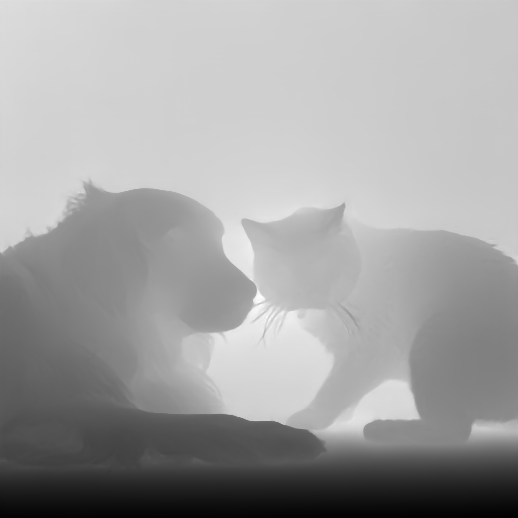

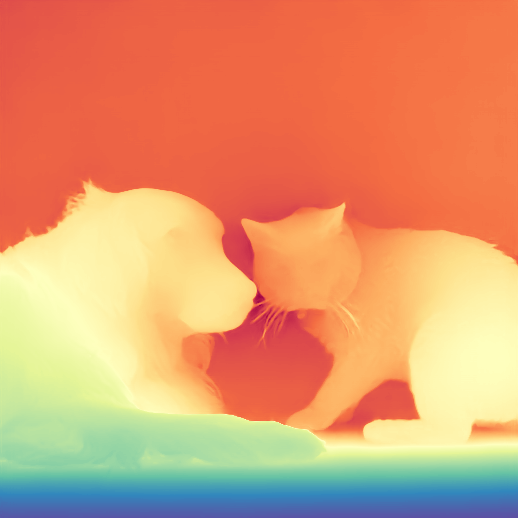

(518, 518)


In [126]:
display(gray_depth)
display(colored_depth_image)
print(depth.shape)

In [ ]:
depth = model.infer_image(input_image,DEVICE=device)
depth.shape

(518, 518)

## Patch the model output

CoreMLTools wants tensors of rank 4 as output. However, DepthAnythingV2 returns a depth map of shap (1, H, W).
Hence, we add a postprocessing step to fix this

In [117]:
class DepthModelWrapper(nn.Module):
    def __init__(self, model):
        super(DepthModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)  # output shape: [B, H, W]

        # 扩展出通道维度 → [B, 1, H, W]
        output_exp = output.unsqueeze(1)

        # 前三个通道复制原始值 → [B, 3, H, W]
        repeated = output_exp.repeat(1, 3, 1, 1)

        # 归一化每个样本的 output → [B, 1, H, W]
        min_vals = output.amin(dim=(1, 2), keepdim=True)
        max_vals = output.amax(dim=(1, 2), keepdim=True)
        normed = (output - min_vals) / (max_vals - min_vals + 1e-6)
        normed = normed.unsqueeze(1)  # → [B, 1, H, W]

        # 拼接：前3通道 + 最后1通道 → [B, 4, H, W]
        out4 = torch.cat([repeated, normed], dim=1)

        return out4.permute(0, 2, 3, 1)

In [118]:
model_wrapper = DepthModelWrapper(model).eval()

## Finally convert

Notice the shape of `input_tensor`: its width is 518 because that's the default input size to DepthAnythingV2.
The height can be any other value as long as it's a multiple of 14.
For simplicity, we make the input have an aspect ratio of 1.
Consequently, the output will have the same aspect ratio.

In [119]:
input_tensor = torch.randn(1, 3, 518, 518).to(device)
traceable_model = torch.jit.trace(model_wrapper, input_tensor)


/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/depth_anything_v2/dinov2_layers/patch_embed.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H % patch_H == 0, f"Input image height {H} is not a multiple of patch height {patch_H}"
/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/depth_anything_v2/dinov2_layers/patch_embed.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert W % patch_W == 0, f"Input image width {W} is not a multiple of patch width: {patch_W}"
/Users/qhong/Documents/MM/motionmodel/3rd/depth/metri

In [133]:
input_tensor = torch.randn(1, 3, 1918, 1008).to(device)
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
traceable_model = torch.jit.trace(model_wrapper, input_tensor)

/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/depth_anything_v2/dinov2_layers/patch_embed.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H % patch_H == 0, f"Input image height {H} is not a multiple of patch height {patch_H}"
/Users/qhong/Documents/MM/motionmodel/3rd/depth/metric_depth/depth_anything_v2/dinov2_layers/patch_embed.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert W % patch_W == 0, f"Input image width {W} is not a multiple of patch width: {patch_W}"
/Users/qhong/Documents/MM/motionmodel/3rd/depth/metri

NotImplementedError: The operator 'aten::upsample_bicubic2d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [123]:
# Set the image scale and bias for input image preprocessing
scale = 1 / (0.226 * 255.0)
bias = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]

# Define the input and output types for the CoreML model
input_name = "input"
output_name = "output"
input_type = ct.ImageType(name=input_name, shape=input_tensor.shape, scale=scale, bias=bias,
                          color_layout=ct.colorlayout.RGB)
output_type = ct.ImageType(name=output_name, color_layout=ct.colorlayout.GRAYSCALE)

# Convert the PyTorch model to CoreML
# If it gets stuck at this step: https://github.com/ggerganov/whisper.cpp/issues/773#issuecomment-1563324684
mlmodel = ct.convert(
    traceable_model,
    convert_to="mlprogram",
    compute_precision=ct.precision.FLOAT32,
    compute_units=ct.ComputeUnit.CPU_AND_GPU,
    inputs=[input_type],
    # inputs = [ct.TensorType(name="image", shape=(1, 3, 518, 518), dtype=np.float32)],
    # outputs = [output_type]
    outputs=[
        ct.TensorType(name="output", dtype=np.float32),
    ],
)

# mlmodel.save(f"DepthAnythingV2{model_name}.mlpackage")
coreml_model_file_name = "Da2.mlpackage"
print(f"Saving model to {coreml_model_file_name}")
mlmodel.save(coreml_model_file_name)
print("Done!")

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 91.71 passes/s]


Saving model to Da2.mlpackage
Done!
